# **Assignment \#4**: Machine Learning MC886/MO444
University of Campinas (UNICAMP), Institute of Computing (IC)

Prof. Sandra Avila, 2022s2

In [1]:
# TODO: RA & Name 
print('RA1:139373 ' + 'Cinthia Cristina Calchi Kleiner')
print('RA2:103897 ' + 'Randerson A Lemos')

RA1:139373 Cinthia Cristina Calchi Kleiner
RA2:103897 Randerson A Lemos


## Objective

Exploring **unsupervised learning techniques** by using dimensionality reduction techniques.

## Import Libraries

In [2]:
# Libraries are free to use! You can use Scikit-learn, Keras/TensorFlow, PyTorch, ... 
import torch
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split 
from tqdm import tqdm

In [3]:
#Setting a SEED for data reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"

## Dataset

Fashion-MNIST is a dataset of Zalando’s article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28×28 grayscale image, associated with a label from 10 classes.

Dataset Information:

- You should respect the following traininig/test split: 60,000 training examples, and 10,000 test examples. Avoid overfitting.

- The data is available at:
https://www.dropbox.com/s/qawunrav8ri0sp4/fashion-mnist-dataset.zip:
‘train’ folder (fashion-mnist train.csv.zip) + ‘test’ folder (fashion-mnist test.csv.zip).

  - You can also download the data by the framework you are using.

- Each training and test example is assigned to one of the following labels: 0 t-shirt/top, 1 trouser, 2 pullover, 3 dress, 4 coat, 5 sandal, 6 shirt, 7 sneaker, 8 bag, 9 ankle boot.
- Each row is a separate image. Column 1 is the class label. The remaining columns are pixel numbers (784 total). Each value is the darkness of the pixel (1 to 255). Dataset was converted to CSV with this script: https://pjreddie.com/projects/mnist-in-csv.

In [4]:
# Download Fashion-MNIST
#->
df = pd.read_csv("../input/fashion-mnist/fashion-mnist_train.csv")
df.iloc[:, 1:] = df.iloc[:, 1:] /255
df.head()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,9,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,6,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019608,0.0,...,0.000000,0.0,0.0,0.117647,0.168627,0.000000,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.003922,0.007843,0.0,0.0,0.000000,0.0,...,0.011765,0.0,0.0,0.000000,0.000000,0.003922,0.0,0.0,0.0,0.0
4,3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


### Data Exploration:

In [5]:
#checking labels destribution
df['label'].value_counts()

2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: label, dtype: int64

In [6]:
#Checking if all pixels are between 0 and 255:
df.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,4.500000,0.000004,0.000024,0.000139,0.000400,0.000972,0.001614,0.003160,0.008621,0.022282,...,0.135786,0.091375,0.065052,0.070076,0.089470,0.070241,0.033414,0.010797,0.003355,0.000275
std,2.872305,0.000371,0.001063,0.004793,0.009619,0.016890,0.022887,0.032216,0.055268,0.093410,...,0.225668,0.191586,0.164626,0.172416,0.203257,0.177056,0.116137,0.068226,0.036694,0.008337
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.227451,0.035294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,0.062745,0.141176,0.886275,0.643137,0.890196,0.901961,0.878431,1.000000,0.996078,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667


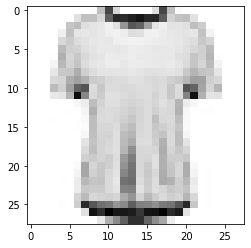

In [7]:
img =  plt.imshow(df.iloc[:,1:].iloc[1500].values.reshape(28,28),cmap='Greys')

### Activities

1. (2 points) Baseline: Explore Convolutional Neural Networks with Fashion-MNIST. What is the accuracy of your CNN model? (1.5 points) Describe your Convolutional Neural Network architecture. (0.5 points) What are your conclusions about the baseline?

In [8]:
##############################################################################################################
#####                                        utils functions
##############################################################################################################

def save_metric_plot(train_metric, val_metric):
    '''
    Create a graph Comparing the validation and train Loss x Epochs
        Args:
            train_metric: list with train metric values
            val_metric: list with val metric values
        Retuns:
            loss.jpg figure 
    '''
    plt.figure(figsize=(10,7))
    plt.plot(train_metric, color='blue', label='train loss')
    plt.plot(val_metric, color='red', label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss.jpg')
    plt.show()
    

def train_val_split(df, train_frac=0.80, val_frac=0.20):
    '''
    Performs train val split of the dataframe
    Args:
        df: input dataframe
        train_frac: train fraction
        val_frac: validation fraction
    Returns:
        train_df: Train dataset
        val_df: Validation dataset
    '''

    # shuffle the dataset
    df = df.sample(frac=1).reset_index(drop=True)
    #train val split the data
    num_train_samples = math.floor(len(df) * train_frac)
    num_val_samples = math.floor(len(df) * val_frac)

    train_df = df[:num_train_samples].reset_index(drop=True)
    val_df = df[-num_val_samples:].reset_index(drop=True)

    return train_df, val_df


def create_new_df(original_df, reduction_result):
    '''
    Create new dataframe based on the dimensionality reduction technique output
    Args:
        original_df: original dataframe
        reduction_result: dimensionality reduction output
    Returns:
        new_df: new df output
    '''
    new_df = original_df.iloc[:, :1].copy()
    new_df[[f"pixel{i}" for i in range(1, reduction_result.shape[1] + 1)]] = reduction_result
    
    return new_df
    
    
def retrain_model(new_df, size):
    """
    Retrain the base model based on the new dataframe
    Args:
        new_df : resulted data frame from PCA or Autoencoder
        size: image size
    """

    train_pca_df, val_pca_df = train_val_split(new_df)
    train_set_pca = FashionMinistDataset(train_pca_df,img_size=size, is_train=True)
    val_set_pca = FashionMinistDataset(val_pca_df,img_size=size, is_train=False)

    #Setting DataLoaders:
    train_loader_pca = DataLoader(train_set_pca, shuffle=True, batch_size=64)
    val_loader_pca = DataLoader(val_set_pca, shuffle=False, batch_size=64)

    model = ConvNetwork()
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    print('Model Architecture')
    print(model)

    train_loss_pca, val_loss_pca, train_metric_pca, val_metric_pca,saved_path = train_network(10, train_loader_pca, val_loader_pca, model, optimizer, criterion, accuracy_score)
    return train_metric_pca, val_metric_pca

In [9]:
#Spliting the data in train and validation steps:

train_df, val_df = train_val_split(df)
print(f'Len df Train: {len(train_df)}, Len df Val: {len(val_df)}')
# print(f'Len X Train: {len(x_train)}, Len X Val: {len(x_val)}, Len y Train: {len(y_train)}, Len X Val: {len(y_val)} ')

Len df Train: 48000, Len df Val: 12000


In [10]:
#DatasetCLass:
class FashionMinistDataset(Dataset):
       
    def __init__(self, df, img_size=28, is_train=True):
        self.data = list(df.values)
        self.is_train = is_train

        img = []
        label = []

        for i in self.data:
            img.append(i[1:])
            label.append(i[0])

        self.imgs = (np.asarray(img).reshape(-1, img_size, img_size, 1)).astype('float32')  
        self.list_labels = np.asarray(label)
      
        if self.is_train:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(p=0.3),
                transforms.RandomVerticalFlip(p=0.3),
                transforms.ToTensor()
            ])
        else: 
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor()
            ])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        img = self.imgs[index]
        img = self.transform(img)
        label = torch.tensor(self.list_labels[index]).long()
#         print(type(img), type(label))
 

        return img, label

    

In [11]:
#Setting Dataset:
train_set = FashionMinistDataset(train_df, is_train=True)
val_set = FashionMinistDataset(val_df, is_train=False)

#Setting DataLoaders:
train_loader = DataLoader(train_set, shuffle=True, batch_size=64)
val_loader = DataLoader(val_set, shuffle=False, batch_size=64)

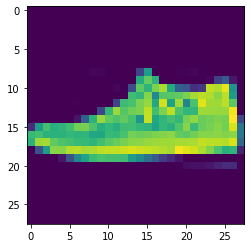

In [12]:
#Checking image and label after dataset pipeline
plt.imshow(train_set[6000][0][0].numpy())

In [13]:
# Create your convolutional neural network architecture

class ConvNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        #Conv1Layer1 
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=7, padding=3),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
#             nn.AvgPool2d(kernel_size=2, stride=2)
        )
        #Conv1Layer2 
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        #Conv1Layer3 
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.drop = nn.Dropout(0.1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_features=128, out_features=10)
        
       
    def forward(self, x):
              
        #Conv1Layer1                      
        output = self.layer1(x)
        #Conv1Layer2
        output = self.layer2(output)
        #Conv1Layer3
        output = self.layer3(output)
        #Reshape --> flatten
        output = self.pool(output)
        output = output.view(output.size(0), -1)
        #dropout
        output = self.drop(output)
        #FullyConnected 1
        output = self.fc1(output)        
        return {"logit": output, "pred": self.postprocess(output)}
    
    def postprocess(self, prob):
        return prob.argmax(dim=1, keepdim=True)

In [14]:
# Train loop

def train_step(model, train_loader, optimizer, criterion, device, metric_fn, epoch, autoencoder=False):
    criterion = criterion.to(device)
    model.train()
    train_running_loss = 0.0
    train_running_metric = 0.0
    pbar = tqdm(train_loader)
    
    for img, target in pbar:
        #Setting data to the right device
        img = img.to(device)
        
        target = target.to(device)
        #Clean Gradients
        optimizer.zero_grad()
        
        output = model(img)
        logit = output["logit"]
        pred = output["pred"]
        
        loss = criterion(logit, target)
        
        if autoencoder:
            metric = metric_fn(target, pred)
        else:
            metric = metric_fn(target.to('cpu').numpy(), pred.to('cpu').numpy())
        
        #Perform Backpropagation
        loss.backward()
        # Setp in the optimizer
        optimizer.step()
        
        train_running_loss += loss.item()
        train_running_metric += metric.item()
        pbar.set_postfix_str(f"Train: Epoch:{epoch}, Loss:{loss.item():.3f}, Metric:{metric.item():.3f}")
    train_loss = train_running_loss / (len(train_loader) + 1)
    train_metric = train_running_metric / (len(train_loader) + 1)
        
    return train_loss, train_metric
        
        
@torch.no_grad()       
def validate_step(model, val_loader, criterion, device, metric_fn, epoch, autoencoder=False):
    criterion = criterion.to(device)
    
    model.eval()
    val_running_loss = 0.0
    val_running_metric = 0.0
    pbar = tqdm(val_loader)
    
    for img, target in pbar:
        #Setting data to the right device
        img = img.to(device)
        target = target.to(device)
        
        
        output = model(img)
        logit = output["logit"]
        pred = output["pred"]
        
        loss = criterion(logit, target)
        if autoencoder:
            #Model Performance
            val_metric = metric_fn(target, pred)
        else:
            val_metric = metric_fn(target.to('cpu').numpy(), pred.to('cpu').numpy())
        
        
        val_running_loss += loss.item()
        val_running_metric += val_metric.item()
        pbar.set_postfix_str(f"Val: Epoch:{epoch}, Loss:{loss.item():.3f}, Metric: {val_metric.item():.3f}")
    val_loss = val_running_loss / (len(val_loader) + 1)
    val_metric = val_running_metric / (len(val_loader) + 1)
        
    return val_loss, val_metric

@torch.no_grad()       
def test_step(model, test_loader, device, metric_fn):
    model.eval()
    test_running_metric = 0.0
    pbar = tqdm(test_loader)
    
    for img, target in pbar:
        #Setting data to the right device
        img = img.to(device)
        target = target.to(device)
        
        
        output = model(img)
        logit = output["logit"]
        pred = output["pred"]
        
        loss = criterion(logit, target)
        test_metric = metric_fn(target.to('cpu').numpy(), pred.to('cpu').numpy())
        test_running_metric += test_metric.item()
        
    test_metric = test_running_metric / (len(test_loader) + 1)
    print(f'Test Accuracy:{test_metric}')
        
    return test_metric
        
    
def train_network(nb_epochs, train_loader, val_loader, model, optimizer, criterion, metric_fc, autoencoder=False):
    train_loss = []
    val_loss = []
    train_metric = []
    val_metric = []
    best_metric = np.inf if autoencoder else 0
    last_save_path = ""

    for epoch in range(nb_epochs):
#         print(f"Epoch {epoch+1} of {EPOCHS}")
        train_epoch_loss, train_epoch_metric = train_step(
            model, train_loader, optimizer, criterion, device, metric_fc, epoch, autoencoder=autoencoder
        )
        val_epoch_loss, val_epoch_metric = validate_step(
            model, val_loader, criterion, device, metric_fc,epoch,autoencoder=autoencoder
        )
            
        #Saving Model
        improved = val_epoch_metric >= best_metric
        if autoencoder:
            improved = not improved
            
        if improved:
            best_metric = val_epoch_metric
            new_path = os.path.join('.', f"best_model_epoch_{epoch+1}_metric_{best_metric:.3f}.ckpt")
            print(f'Saving Model {new_path}')
            torch.save(model.state_dict(), new_path)
            print(train_epoch_metric)
            print(val_epoch_metric)
            if os.path.exists(last_save_path):
                os.remove(last_save_path)
            last_save_path = new_path
            
        train_loss.append(train_epoch_loss)
        val_loss.append(val_epoch_loss)
        train_metric.append(train_epoch_metric)
        val_metric.append(val_epoch_metric)
        
    return train_loss, val_loss, train_metric, val_metric, last_save_path

    

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ConvNetwork()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print('Model Architecture')
print(model)

train_loss, val_loss, train_metric, val_metric, conv_last_save_path = train_network(20, train_loader, val_loader, model, optimizer, criterion, accuracy_score)

Model Architecture
ConvNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (drop): Dropout(p=0.1, inplace=False)
  (pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)


100%|██████████| 188/188 [00:01<00:00, 102.94it/s, Val: Epoch:0, Loss:0.889, Metric: 0.688]


Saving Model ./best_model_epoch_1_metric_0.741.ckpt
0.7225574234354194
0.7407407407407407


100%|██████████| 188/188 [00:01<00:00, 101.35it/s, Val: Epoch:1, Loss:0.688, Metric: 0.719]


Saving Model ./best_model_epoch_2_metric_0.751.ckpt
0.7990179760319573
0.7509920634920635


100%|██████████| 188/188 [00:01<00:00, 99.46it/s, Val: Epoch:2, Loss:0.677, Metric: 0.719] 


Saving Model ./best_model_epoch_3_metric_0.801.ckpt
0.8228819906790945
0.8013392857142857


100%|██████████| 188/188 [00:02<00:00, 90.43it/s, Val: Epoch:3, Loss:0.491, Metric: 0.812]


Saving Model ./best_model_epoch_4_metric_0.844.ckpt
0.8332015645805593
0.8439980158730159


100%|██████████| 188/188 [00:01<00:00, 102.79it/s, Val: Epoch:5, Loss:0.497, Metric: 0.812]


Saving Model ./best_model_epoch_6_metric_0.851.ckpt
0.8487433422103862
0.8513558201058201


100%|██████████| 188/188 [00:01<00:00, 99.18it/s, Val: Epoch:6, Loss:0.462, Metric: 0.781] 


Saving Model ./best_model_epoch_7_metric_0.852.ckpt
0.854090379494008
0.8516038359788359


100%|██████████| 188/188 [00:01<00:00, 102.18it/s, Val: Epoch:7, Loss:0.372, Metric: 0.812]


Saving Model ./best_model_epoch_8_metric_0.867.ckpt
0.8564206058588548
0.8673941798941799


100%|██████████| 188/188 [00:01<00:00, 103.78it/s, Val: Epoch:9, Loss:0.413, Metric: 0.875]


Saving Model ./best_model_epoch_10_metric_0.878.ckpt
0.8638482023968043
0.8775628306878307


100%|██████████| 188/188 [00:01<00:00, 100.84it/s, Val: Epoch:14, Loss:0.406, Metric: 0.812]


Saving Model ./best_model_epoch_15_metric_0.881.ckpt
0.877184587217044
0.8812830687830688


100%|██████████| 188/188 [00:02<00:00, 90.44it/s, Val: Epoch:15, Loss:0.424, Metric: 0.875]


Saving Model ./best_model_epoch_16_metric_0.884.ckpt
0.8772678095872171
0.8835152116402116


100%|██████████| 188/188 [00:01<00:00, 102.10it/s, Val: Epoch:18, Loss:0.362, Metric: 0.844]


Saving Model ./best_model_epoch_19_metric_0.889.ckpt
0.8814497336884154
0.888806216931217


100%|██████████| 188/188 [00:01<00:00, 102.56it/s, Val: Epoch:19, Loss:0.639, Metric: 0.812]


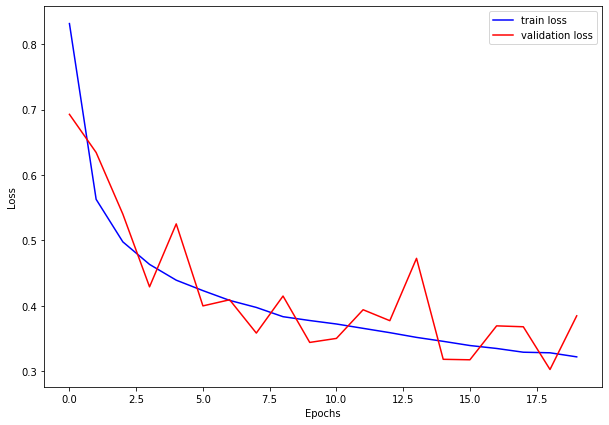

In [16]:
save_metric_plot(train_loss, val_loss)

In [17]:
# Report your accuracy using convolutional neural network
# Testing the neural net in the test data:

df_test = pd.read_csv("../input/test-mnist/fashion-mnist_test.csv")
df_test.iloc[:, 1:] = df_test.iloc[:, 1:] /255
df_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.035294,0.031373,...,0.403922,0.341176,0.219608,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.133333,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.054902,0.207843,0.388235,...,0.000000,0.000000,0.000000,0.0,0.247059,0.207843,0.121569,0.000000,0.0,0.0
3,2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.537255,0.494118,0.549020,0.0,0.521569,0.878431,0.870588,0.219608,0.0,0.0
4,3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [18]:
test_set = FashionMinistDataset(df_test, is_train=False)

#Setting DataLoaders:
test_loader = DataLoader(test_set, shuffle=False, batch_size=64)

#Loading the model:
model = model.to(device)
model.load_state_dict(torch.load(conv_last_save_path))

test_metric = test_step(model, test_loader,device, accuracy_score)


100%|██████████| 157/157 [00:01<00:00, 123.04it/s]

Test Accuracy:0.8894382911392406


#### Model Architecture: 
The model architecture designed for the Fashion Mnist problem consists of 3 convolutional blocks. In the first block, the convolution operation is applied using a kernel size of 7. Then, data normalization is applied through the technique that batch normalization in two dimensions. FIially, the Relu activation function was applied. The following two convolutional blocks differ slightly from the first one. he first change point is the kernel size in convolution operations which is now 3. These two blocks also have a new layer after the ed function is activated: average pooling 2D. In the first experiments carried out, the first convolutional block also had this last pooling layer, however the training was not successful  in cases where there was a dimensional reduction (PCA or Autoencoder) since the pooling operation resulted in very small sizes which could not be processed.
After the three convolutional blocks, an adaptative average pooling 2d was applied in order to flatten the tensor. Then a fully connected layer with drop out (10%) was applied. 

#### What are your conclusions about the baseline? 
With the baseline results, it is possible to note that an convolutional neural network with few layers (4 convolutional layers followed py a fully conenct layer) was able to handle the fashion mnist issue getting reasonable metrics.The following table reports the performance of the model

|Model |Train Acc|Val Acc|Test Acc|
|-----|--------|--------|--------|
|Baseline|    0.8814|0.8888|0.8894|

In order to improve the metrics some approaches can be considered: more agressive data augmentation in the trainning step, increasing the model ability to generalise the problem classes. Futhermore, it is possible to add more layers in the model architecture and add other regularization techniques.



2. (2 points) Using PCA: Re-do the first experiment considering the PCA dimensionality reduction. (1.5 points) Consider two different energies (variance) for reducing the image dimensionality. (0.5 points) What are the conclusions when using PCA in this problem? Does the accuracy improve?

In [19]:
# Run PCA methods
features_df = df.drop(['label'], axis=1)
features_df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019608,0.0,0.0,...,0.000000,0.0,0.0,0.117647,0.168627,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.003922,0.007843,0.0,0.0,0.000000,0.0,0.0,...,0.011765,0.0,0.0,0.000000,0.000000,0.003922,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


In [20]:
def calculate_pca_and_variance(components, original_df, df_features):
    '''
    Calculates PCA transform and variance of it
    Args:
        components: nº of components to pca operation
        original_df: original dataframe
        df_features: features dataframe
    Returns:
        Pca output: pca output
    '''
    pca = PCA(n_components=components)
    pca_output = pca.fit_transform(df_features)
    variance = sum(pca.explained_variance_ratio_)
    print(f'Num. of PCA componentes {components} and variance {variance}')
    return pca_output



In [21]:
#First PCA: New image size: 22 x 22
pca_484 = calculate_pca_and_variance(484,df,features_df)
df_pca_484 = create_new_df(df, pca_484)

#Second PCA: New image size: 12 x 12
pca_144 = calculate_pca_and_variance(144,df,features_df)
df_pca_144 = create_new_df(df, pca_144)


Num. of PCA componentes 484 and variance 0.9914870125313527


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


Num. of PCA componentes 144 and variance 0.9346110157871551


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


In [22]:
# Re-do the first experiment considering the PCA dimensionality reduction
#train
pca_484_train_acc,pca_484_val_acc  = retrain_model(df_pca_484, 22)
print(f'Best Model Accuracy Train Step: {max(pca_484_train_acc)}')
print(f'Best Model Accuracy Validation Step: {max(pca_484_val_acc)}')


pca_144_train_acc,pca_144_val_acc = retrain_model(df_pca_144, 12)
print(f'Best Model Accuracy Train Step: {max(pca_144_train_acc)}')
print(f'Best Model Accuracy Validation Step: {max(pca_144_val_acc)}')


Model Architecture
ConvNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (drop): Dropout(p=0.1, inplace=False)
  (pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)


100%|██████████| 188/188 [00:01<00:00, 106.33it/s, Val: Epoch:0, Loss:1.543, Metric: 0.500]


Saving Model ./best_model_epoch_1_metric_0.596.ckpt
0.6260402796271638
0.5962301587301587


100%|██████████| 188/188 [00:02<00:00, 92.87it/s, Val: Epoch:2, Loss:0.752, Metric: 0.656] 


Saving Model ./best_model_epoch_3_metric_0.763.ckpt
0.7724076231691078
0.7631448412698413


100%|██████████| 188/188 [00:01<00:00, 101.06it/s, Val: Epoch:3, Loss:0.532, Metric: 0.812]


Saving Model ./best_model_epoch_4_metric_0.815.ckpt
0.788802430093209
0.814566798941799


100%|██████████| 188/188 [00:01<00:00, 106.19it/s, Val: Epoch:7, Loss:0.636, Metric: 0.812]


Saving Model ./best_model_epoch_8_metric_0.838.ckpt
0.8224450732356857
0.837880291005291


100%|██████████| 188/188 [00:01<00:00, 105.15it/s, Val: Epoch:9, Loss:0.419, Metric: 0.906]


Best Model Accuracy Train Step: 0.8284370838881492
Best Model Accuracy Validation Step: 0.837880291005291
Model Architecture
ConvNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (drop): Dropout(p=0.1, inplace=False)
  (pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=128, out_feature

100%|██████████| 188/188 [00:01<00:00, 112.42it/s, Val: Epoch:0, Loss:0.819, Metric: 0.781]


Saving Model ./best_model_epoch_1_metric_0.713.ckpt
0.7105734021304927
0.712880291005291


100%|██████████| 188/188 [00:01<00:00, 111.14it/s, Val: Epoch:2, Loss:0.760, Metric: 0.750]


Saving Model ./best_model_epoch_3_metric_0.784.ckpt
0.8095248002663116
0.7840608465608465


100%|██████████| 188/188 [00:01<00:00, 95.69it/s, Val: Epoch:4, Loss:0.900, Metric: 0.719] 


Saving Model ./best_model_epoch_5_metric_0.791.ckpt
0.826460552596538
0.791005291005291


100%|██████████| 188/188 [00:01<00:00, 108.95it/s, Val: Epoch:5, Loss:0.881, Metric: 0.719]


Saving Model ./best_model_epoch_6_metric_0.803.ckpt
0.8324941744340879
0.8034887566137566


100%|██████████| 188/188 [00:01<00:00, 101.60it/s, Val: Epoch:6, Loss:0.787, Metric: 0.688]


Saving Model ./best_model_epoch_7_metric_0.803.ckpt
0.8374667110519307
0.8034887566137566


100%|██████████| 188/188 [00:01<00:00, 107.78it/s, Val: Epoch:7, Loss:0.517, Metric: 0.750]


Saving Model ./best_model_epoch_8_metric_0.848.ckpt
0.8415029960053262
0.847635582010582


100%|██████████| 188/188 [00:01<00:00, 109.86it/s, Val: Epoch:9, Loss:0.535, Metric: 0.750]

Best Model Accuracy Train Step: 0.8499292609853528
Best Model Accuracy Validation Step: 0.847635582010582


The results obtained in the exercise demonstrate that the accuracy of the model did not improve with the implementation of the PCA technique.In both evaluated cases, the performance in the training and validation sets were similar. It was also noted that in both  different energies (variance) used, 
the performance of the moedel was not much affected com by the reduction of dimensionality.

|Model |Train Acc|Val Acc|
|-----|--------|--------|
|Baseline|    0.8814|0.888|
|PCA 484  |0.8285  |0.8181|
|PCA 144  |     0.8499 |0.8476|

3. (0.5 point) What can we infer when analyzing the breakdown of data into components using a chart to plot the data in 2-dimensional space to view separation?

In [23]:
# In order to see how the PCA components are separating out the digits, lets use the following method, plot_components, to plot the data in a 2 dimensional space to view separation.
# The input parameters are the PCA fit in X and the labels
def plot_components(X, y):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure(figsize=(10, 6))
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]), 
                 color=plt.cm.Set1(y[i]), 
                 fontdict={'size': 15})

    plt.xticks([]), plt.yticks([]), plt.ylim([-0.1,1.1]), plt.xlim([-0.1,1.1])

In [24]:
y = np.hstack(df.iloc[:, :1].values)

In [25]:
pca = PCA(n_components=144)
pca_144 = pca.fit(features_df)
pca_transform_144 = pca.transform(features_df)

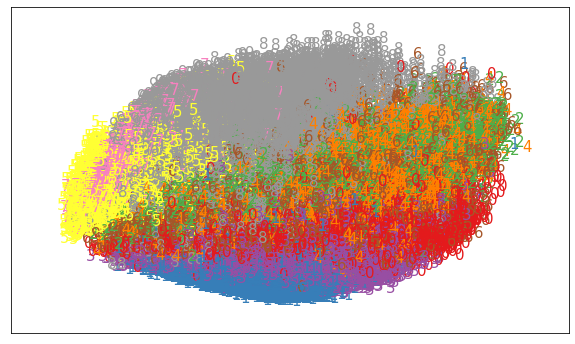

In [26]:
# The input parameters are the PCA fit in X and the labels

plot_components(pca_transform_144, y)

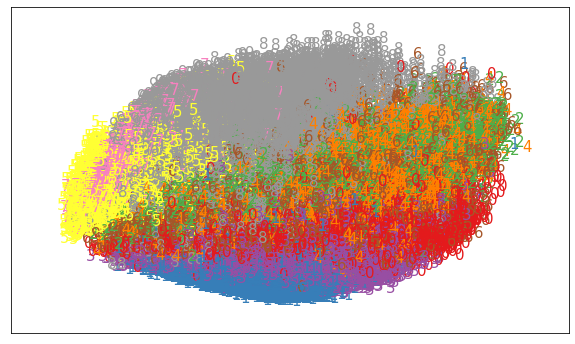

In [27]:
pca = PCA(n_components=484)
pca_484 = pca.fit(features_df)
pca_transform_484 = pca.transform(features_df)
plot_components(pca_transform_484, y)

Evaluating the 2d space to understand the separability between the classes present in the data, it is noted that despite the existence of an intersection between the classes, layers of separation can be found between them. It was not possible to notice difference in the plots with 144 and 484 components

4. (2 points) How many components are needed for a better evaluation of the model? Define the minimum and maximum components to be tested using the energies_number method. How can we evaluate this graph and the quantity that was defined as best for the problem?

In [28]:
# Iteratively check how many principal components would be required in order to reach a reasonable accuracy with the same random neural network.

def energies_number(min_value, max_value, X):
    # Select a range of min and max number of dimensions, min/max.

    acc_list, pc_list = [], []
    for pc in range(min_value,max_value):
        num_components = int(pc ** 2)
        pca = calculate_pca_and_variance(num_components, df, features_df)# Run the PCA algorithm for dimensionality reduction.
        pca_df = create_new_df(df, pca)
        print(pca_df.shape)
        pca_train_acc, pca_val_acc = retrain_model(pca_df, pc)
        acc = max(pca_val_acc)# C}alculate the accuracy of the neural network using the reduced dimension by PCA
        acc_list.append(acc)
        pc_list.append(pc)
    return acc_list, pc_list

acc_list, pc_list = energies_number(10, 14 ,features_df)
pc_list  = list(map(lambda x:pow(x,2),pc_list))                                 
  

Num. of PCA componentes 100 and variance 0.9117963851718149
(60000, 101)


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


Model Architecture
ConvNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (drop): Dropout(p=0.1, inplace=False)
  (pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)


100%|██████████| 188/188 [00:01<00:00, 112.47it/s, Val: Epoch:0, Loss:1.321, Metric: 0.594]


Saving Model ./best_model_epoch_1_metric_0.619.ckpt
0.7243675099866844
0.6190476190476191


100%|██████████| 188/188 [00:01<00:00, 110.34it/s, Val: Epoch:1, Loss:0.636, Metric: 0.812]


Saving Model ./best_model_epoch_2_metric_0.779.ckpt
0.7999334221038615
0.779183201058201


100%|██████████| 188/188 [00:01<00:00, 109.60it/s, Val: Epoch:2, Loss:0.452, Metric: 0.844]


Saving Model ./best_model_epoch_3_metric_0.813.ckpt
0.8201356524633822
0.812582671957672


100%|██████████| 188/188 [00:02<00:00, 89.71it/s, Val: Epoch:3, Loss:0.334, Metric: 0.906]


Saving Model ./best_model_epoch_4_metric_0.838.ckpt
0.8264397470039947
0.8381283068783069


100%|██████████| 188/188 [00:01<00:00, 95.15it/s, Val: Epoch:9, Loss:0.555, Metric: 0.875] 


Num. of PCA componentes 121 and variance 0.9240680311175556
(60000, 122)


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


Model Architecture
ConvNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (drop): Dropout(p=0.1, inplace=False)
  (pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)


100%|██████████| 188/188 [00:01<00:00, 109.28it/s, Val: Epoch:0, Loss:1.121, Metric: 0.688]


Saving Model ./best_model_epoch_1_metric_0.711.ckpt
0.7166278295605859
0.7111441798941799


100%|██████████| 188/188 [00:01<00:00, 110.83it/s, Val: Epoch:1, Loss:0.540, Metric: 0.812]


Saving Model ./best_model_epoch_2_metric_0.771.ckpt
0.7981025299600533
0.7706679894179894


100%|██████████| 188/188 [00:01<00:00, 108.14it/s, Val: Epoch:2, Loss:0.486, Metric: 0.875]


Saving Model ./best_model_epoch_3_metric_0.840.ckpt
0.8193450399467377
0.8401951058201058


100%|██████████| 188/188 [00:01<00:00, 100.89it/s, Val: Epoch:8, Loss:0.519, Metric: 0.781]


Saving Model ./best_model_epoch_9_metric_0.844.ckpt
0.8540487683089214
0.8441633597883598


100%|██████████| 188/188 [00:01<00:00, 113.05it/s, Val: Epoch:9, Loss:0.524, Metric: 0.844]


Num. of PCA componentes 144 and variance 0.9345962699082816
(60000, 145)


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


Model Architecture
ConvNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (drop): Dropout(p=0.1, inplace=False)
  (pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)


100%|██████████| 188/188 [00:01<00:00, 109.51it/s, Val: Epoch:0, Loss:1.089, Metric: 0.688]


Saving Model ./best_model_epoch_1_metric_0.630.ckpt
0.7081391478029294
0.6295469576719577


100%|██████████| 188/188 [00:01<00:00, 110.51it/s, Val: Epoch:1, Loss:0.925, Metric: 0.656]


Saving Model ./best_model_epoch_2_metric_0.726.ckpt
0.7922769640479361
0.7256117724867724


100%|██████████| 188/188 [00:01<00:00, 111.26it/s, Val: Epoch:2, Loss:0.689, Metric: 0.750]


Saving Model ./best_model_epoch_3_metric_0.799.ckpt
0.8089630492676432
0.798776455026455


100%|██████████| 188/188 [00:01<00:00, 110.91it/s, Val: Epoch:6, Loss:0.507, Metric: 0.781]


Saving Model ./best_model_epoch_7_metric_0.822.ckpt
0.8380284620505992
0.8217592592592593


100%|██████████| 188/188 [00:01<00:00, 95.72it/s, Val: Epoch:7, Loss:0.715, Metric: 0.750] 


Saving Model ./best_model_epoch_8_metric_0.831.ckpt
0.8391935752330226
0.8311011904761905


100%|██████████| 188/188 [00:01<00:00, 108.17it/s, Val: Epoch:9, Loss:0.384, Metric: 0.906]


Num. of PCA componentes 169 and variance 0.9438603905570515
(60000, 170)


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


Model Architecture
ConvNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (drop): Dropout(p=0.1, inplace=False)
  (pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)


100%|██████████| 188/188 [00:01<00:00, 104.98it/s, Val: Epoch:0, Loss:1.443, Metric: 0.531]


Saving Model ./best_model_epoch_1_metric_0.665.ckpt
0.6953437083888149
0.6652612433862434


100%|██████████| 188/188 [00:01<00:00, 96.53it/s, Val: Epoch:2, Loss:1.243, Metric: 0.594] 


Saving Model ./best_model_epoch_3_metric_0.781.ckpt
0.8049267643142477
0.7806712962962963


100%|██████████| 188/188 [00:01<00:00, 111.44it/s, Val: Epoch:4, Loss:0.763, Metric: 0.719]


Saving Model ./best_model_epoch_5_metric_0.792.ckpt
0.8243383821571239
0.7924107142857143


100%|██████████| 188/188 [00:01<00:00, 95.42it/s, Val: Epoch:6, Loss:0.583, Metric: 0.688] 


Saving Model ./best_model_epoch_7_metric_0.818.ckpt
0.8362807922769641
0.8177910052910053


100%|██████████| 188/188 [00:01<00:00, 111.89it/s, Val: Epoch:7, Loss:0.542, Metric: 0.781]


Saving Model ./best_model_epoch_8_metric_0.819.ckpt
0.8395680758988016
0.8193617724867724


100%|██████████| 188/188 [00:01<00:00, 97.20it/s, Val: Epoch:9, Loss:0.627, Metric: 0.781] 


Saving Model ./best_model_epoch_10_metric_0.840.ckpt
0.8451647802929427
0.8400297619047619


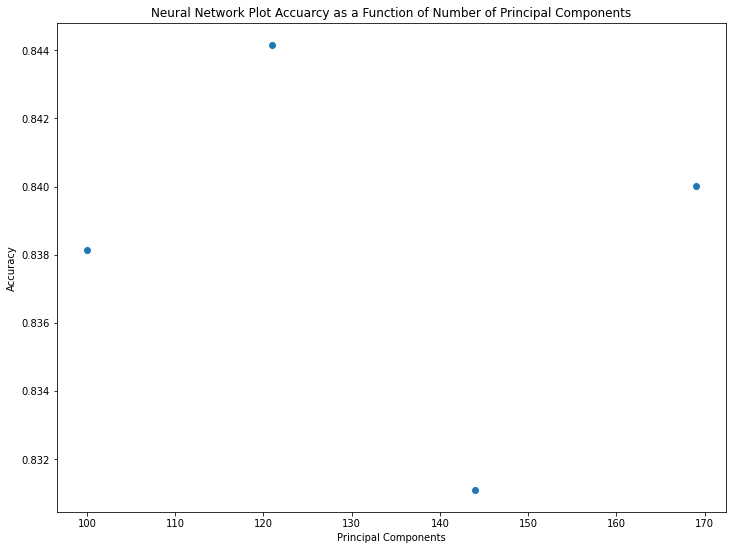

In [29]:
plt.figure(figsize=[12,9])
plt.scatter(pc_list, acc_list)
plt.title('Neural Network Plot Accuarcy as a Function of Number of Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Accuracy');

In [30]:
print('The maximum accuracy attained is ',np.max(acc_list),'% with ',pc_list[np.where(acc_list == np.max(acc_list))[0][0]],' principal components. Beyond this peak, additional principal components appear to mostly contribute noise.')

The maximum accuracy attained is  0.8441633597883598 % with  121  principal components. Beyond this peak, additional principal components appear to mostly contribute noise.


With an observation of the results obtained in the exercise experiment. It was noted that even with only 100 components, the model performed similary well. The obtained metrics oto the baseline performance. The metrics obtained with the baseline retraining with the PCA outputs had lower values than those obtained with the convolutional network operating on the untouched data. Despite the accuracy values being lower, the difference was not significant (less then 1%);

5. (3.5 points) Using Autoencoders: Re-do the first experiment (question 2) considering Autoencoders for reducing the image dimensionality. (3 points) Consider two different latent vector sizes for reducing the image dimensionality. (0.5 points) What are the conclusions when using Autoencoders in this problem? Does accuracy improve? 

Autoencoders are a branch of neural networks which attempt to compress the information of the input variables into a reduced dimensional space and then recreate the input data set. Typically the autoencoder is trained over some iterations using gradient descent, minimizing the mean squared error.
The key component is the “bottleneck” hidden layer. This is where the information from the input has been compressed. By extracting this layer from the model, each node can be treated as a variable in the same way each chosen principal component is used in the following models.

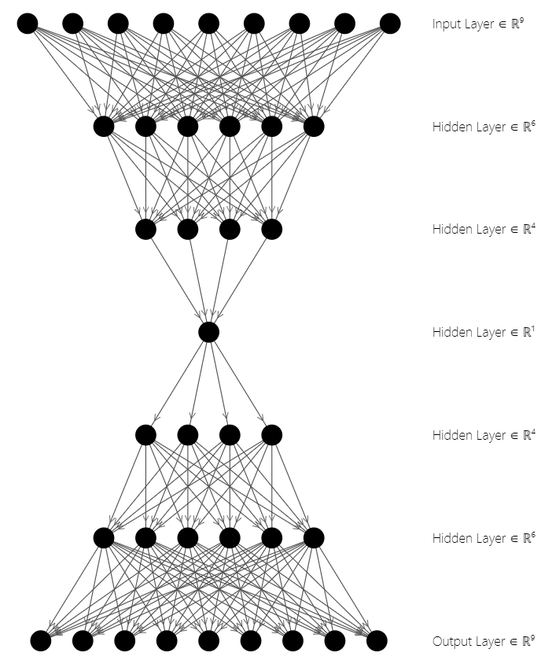

In [31]:
# Create your AutoEncoder network architecture:
def train_autoencoder(latent_space_dim, train_encoder_loader,val_encoder_loader):
    """
    Train an autoencoder neural network based on latent space dimension
    Args:
        latent_space_dim: latent space dimension
        train_encoder_loader: train encoder dataloader
        val_encoder_loader: val encoder dataloader
    """
    model = Autoencoder(latent_space=latent_space_dim)
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    print('Model Architecture')
    print(model)

    train_loss, val_loss, train_metric, val_metric,path_autoencoder = train_network(20,train_encoder_loader,val_encoder_loader, model,optimizer, criterion, criterion, autoencoder=True)
    return path_autoencoder

def get_encoder_decoder(space, model_path, loader):
    '''
    Obtain the values of the encoder and the decoder outputs
    Args:
        space: latent space dim
        model_path: saved model path 
        loader: dataloader to the pipeline
    Returns:
        enc_list: list with the encoder output
        decoder_ouput: list with the decoder output
    '''
    #Getting State Dict from trainned model
    model = Autoencoder(latent_space=space).to(device)
    model.load_state_dict(torch.load(model_path))
    enc_list, decoder_output = get_latent_space(model, loader, device)
    print(f'Min Value Encoder: {enc_list.min()}, Max Value: {enc_list.max()}')
    return enc_list, decoder_output

def encoder_to_df_pipeline(space, model_path, loader,size):
    '''
    Pipeline to transform encoder output into a new dataframe
    Some visualization are shown in the process
    Args:
        space: latent space dim
        model_path: saved model path 
        loader: dataloader to the pipeline
    Returns:
        df_encoder: new df with the encoder information
    '''
    enc_list, decoder_output = get_encoder_decoder(space,model_path, loader)
    #Creating dataframe with the decoder output:
    df_decoder = create_new_df(df, decoder_output)

    #Creating a new dataframe with the encoded values
    df_encoder = create_new_df(df, enc_list)
    print('\n')
    print('Visualizing the latent vector of one image and some reconstructions examples')
    plt.imshow(df_encoder.iloc[4, 1:].values.reshape(size, size), cmap='gray')
    plt.title('latent vector')
    ##Seeing some reconstructed images:
    fig, axes = plt.subplots(2, 3,figsize=(12,12), subplot_kw={'xticks':[], 'yticks':[]})
    for i in range(6):
        orig = (df.iloc[i, 1:].values.reshape(28, 28)*255)
    #     encoded = new_df[i, 1:].values.reshape(22, 22)
        decoded = (df_decoder.iloc[i, 1:].values.reshape(28, 28) * 255)
        together = np.concatenate((orig, decoded), axis=1)
        ax = axes.flat[i]
        ax.imshow(together,cmap='gray')
        ax.set_title('original - decoded')
   
    plt.subplots_adjust(wspace=0.02, hspace=-0.6)
    return df_encoder

@torch.no_grad()
def get_latent_space(model, loader, device):
    """
    Performs Dimensitonality Reduction based in a trainned autoencoder model
    Args:
        model: trainned model
        loader: dataloader
        device: gpu or cpu
    Returns:
        enc_list: list of the encoded images
    """
    model.eval()
    enc_list = []
    out_decoder_list = []
    pbar = tqdm(loader)
    
    for img, target in pbar:
        #Setting data to the right device
        img = img.to(device)
        target = target.to(device)
        output = model(img)
        enc = output['enc']
        dec = output['pred']
        
        enc_list.append(enc)
        out_decoder_list.append(dec)
    #tensor dataset, widht 
    enc_list = torch.cat(enc_list).cpu().numpy()
    out_decoder_list = torch.cat(out_decoder_list).cpu().numpy()
    return enc_list, out_decoder_list


#AutoEncoder Dataset Class
class AutoencoderDataset(FashionMinistDataset):
    def __init__(self, df):
        self.df = df
        self.data = list(df.values)
        img = []
        for i in self.data:
            img.append(i[1:])
            
        self.imgs = (np.asarray(img)).astype('float32')  
            
    def __getitem__(self, index):
        img = self.imgs[index]
        img = torch.from_numpy(img).float()
        #(1,28*28)
        return img, img
#Encoder
class Encoder(nn.Module):
    def __init__(self, latente):
        super().__init__()
        self.layer1 = nn.Linear(784, 712)
        self.layer2 = nn.Linear(712, 640)
        self.layer3 = nn.Linear(640, 512)
        self.layer4 = nn.Linear(512, latente)
        
    def forward(self, x):
        #Conv1Layer1                      
        output = F.relu(self.layer1(x))
        #Conv1Layer12                     
        output = F.relu(self.layer2(output))
        #Conv1Layer3                      
        output = F.relu(self.layer3(output))
        #Conv1Layer4                      
        output = self.layer4(output)
       
        return output
#Decoder   
class Decoder(nn.Module):
    def __init__(self, latent_space):
        super().__init__()
        self.layer1 = nn.Linear(latent_space, 512)
        self.layer2 = nn.Linear(512,640 )
        self.layer3 = nn.Linear(640, 712)
        self.layer4 = nn.Linear(712, 784)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
              
        #Conv1Layer1                      
        output = F.relu(self.layer1(x))
        #Conv1Layer12                     
        output = F.relu(self.layer2(output))
        #Conv1Layer3                      
        output = F.relu(self.layer3(output))
        #Conv1Layer4                      
        output = self.layer4(output)
        #Sigmoid
        output = self.sigmoid(output)
        return output

#Decoder   
class Autoencoder(nn.Module):
    def __init__(self, latent_space):
        super().__init__()
        self.encoder = Encoder(latent_space)
        self.decoder = Decoder(latent_space)
        
    def forward(self, x):
        x_encoder = self.encoder(x)
        x_decoder = self.decoder(F.relu(x_encoder))
        
        return {"logit": x_decoder, "pred": x_decoder, "enc": torch.sigmoid(x_encoder)}

In [32]:
# Re-do the first experiment (question 2) considering the autoencoder dimensionality reduction

#Setting Dataset:
train_set_encoder = AutoencoderDataset(train_df)
val_set_encoder = AutoencoderDataset(val_df)

#Setting DataLoaders:
train_encoder_loader = DataLoader(train_set_encoder, shuffle=True, batch_size=64)
val_encoder_loader = DataLoader(val_set_encoder, shuffle=False, batch_size=64)

Trainning Auto Encoder Model with latent space of 484


Model Architecture
Autoencoder(
  (encoder): Encoder(
    (layer1): Linear(in_features=784, out_features=712, bias=True)
    (layer2): Linear(in_features=712, out_features=640, bias=True)
    (layer3): Linear(in_features=640, out_features=512, bias=True)
    (layer4): Linear(in_features=512, out_features=484, bias=True)
  )
  (decoder): Decoder(
    (layer1): Linear(in_features=484, out_features=512, bias=True)
    (layer2): Linear(in_features=512, out_features=640, bias=True)
    (layer3): Linear(in_features=640, out_features=712, bias=True)
    (layer4): Linear(in_features=712, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
)


100%|██████████| 188/188 [00:00<00:00, 345.18it/s, Val: Epoch:0, Loss:0.027, Metric: 0.027]


Saving Model ./best_model_epoch_1_metric_0.024.ckpt
0.0383679215832255
0.02411935471550182


100%|██████████| 188/188 [00:00<00:00, 286.84it/s, Val: Epoch:1, Loss:0.024, Metric: 0.024]


Saving Model ./best_model_epoch_2_metric_0.021.ckpt
0.022568821517648933
0.021335912809248955


100%|██████████| 188/188 [00:00<00:00, 347.02it/s, Val: Epoch:2, Loss:0.022, Metric: 0.022]


Saving Model ./best_model_epoch_3_metric_0.020.ckpt
0.020636486634860104
0.020232140367466307


100%|██████████| 188/188 [00:00<00:00, 330.92it/s, Val: Epoch:3, Loss:0.020, Metric: 0.020]


Saving Model ./best_model_epoch_4_metric_0.019.ckpt
0.019450931047174966
0.01867263585269924


100%|██████████| 188/188 [00:00<00:00, 334.01it/s, Val: Epoch:4, Loss:0.019, Metric: 0.019]


Saving Model ./best_model_epoch_5_metric_0.018.ckpt
0.018254915144438354
0.017564471914536424


100%|██████████| 188/188 [00:00<00:00, 335.43it/s, Val: Epoch:5, Loss:0.019, Metric: 0.019]


Saving Model ./best_model_epoch_6_metric_0.017.ckpt
0.017357371442426696
0.01711402718155157


100%|██████████| 188/188 [00:00<00:00, 323.07it/s, Val: Epoch:6, Loss:0.018, Metric: 0.018]


Saving Model ./best_model_epoch_7_metric_0.016.ckpt
0.01643169606439323
0.016114738208079148


100%|██████████| 188/188 [00:00<00:00, 311.23it/s, Val: Epoch:7, Loss:0.017, Metric: 0.017]


Saving Model ./best_model_epoch_8_metric_0.016.ckpt
0.015762614806774215
0.015553543496896666


100%|██████████| 188/188 [00:00<00:00, 343.45it/s, Val: Epoch:8, Loss:0.017, Metric: 0.017]


Saving Model ./best_model_epoch_9_metric_0.015.ckpt
0.015031158628956615
0.014743358458554933


100%|██████████| 188/188 [00:00<00:00, 341.41it/s, Val: Epoch:9, Loss:0.016, Metric: 0.016]


Saving Model ./best_model_epoch_10_metric_0.014.ckpt
0.014375164301274779
0.014252832913327785


100%|██████████| 188/188 [00:00<00:00, 279.23it/s, Val: Epoch:10, Loss:0.015, Metric: 0.015]


Saving Model ./best_model_epoch_11_metric_0.014.ckpt
0.013966787782573351
0.013867333112530923


100%|██████████| 188/188 [00:00<00:00, 341.87it/s, Val: Epoch:12, Loss:0.015, Metric: 0.015]


Saving Model ./best_model_epoch_13_metric_0.013.ckpt
0.01325086148557428
0.013334834278024062


100%|██████████| 188/188 [00:00<00:00, 363.29it/s, Val: Epoch:13, Loss:0.015, Metric: 0.015]


Saving Model ./best_model_epoch_14_metric_0.013.ckpt
0.012952526863887608
0.013249613822649711


100%|██████████| 188/188 [00:00<00:00, 317.11it/s, Val: Epoch:14, Loss:0.014, Metric: 0.014]


Saving Model ./best_model_epoch_15_metric_0.013.ckpt
0.012733171903559276
0.01308325470164024


100%|██████████| 188/188 [00:00<00:00, 327.06it/s, Val: Epoch:15, Loss:0.014, Metric: 0.014]


Saving Model ./best_model_epoch_16_metric_0.013.ckpt
0.012475605460054945
0.012837454233141173


100%|██████████| 188/188 [00:00<00:00, 283.56it/s, Val: Epoch:16, Loss:0.013, Metric: 0.013]


Saving Model ./best_model_epoch_17_metric_0.013.ckpt
0.01229138571158865
0.012511860534903548


100%|██████████| 188/188 [00:00<00:00, 312.25it/s, Val: Epoch:18, Loss:0.013, Metric: 0.013]


Saving Model ./best_model_epoch_19_metric_0.012.ckpt
0.01192700372669057
0.012298735380961151


100%|██████████| 188/188 [00:00<00:00, 344.44it/s, Val: Epoch:19, Loss:0.013, Metric: 0.013]




Retraining the Baseline Model with the encoder output


100%|██████████| 938/938 [00:01<00:00, 901.35it/s] 


Min Value Encoder: 1.3332441994862165e-05, Max Value: 0.9999611377716064


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)




Visualizing the latent vector of one image and some reconstructions examples
Model Architecture
ConvNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (drop): Dropout(p=0.1, inplace=False)
  (pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)


100%|██████████| 188/188 [00:01<00:00, 98.99it/s, Val: Epoch:0, Loss:4.358, Metric: 0.281] 


Saving Model ./best_model_epoch_1_metric_0.277.ckpt
0.7185835552596538
0.27662037037037035


100%|██████████| 188/188 [00:01<00:00, 100.94it/s, Val: Epoch:1, Loss:1.511, Metric: 0.719]


Saving Model ./best_model_epoch_2_metric_0.640.ckpt
0.7987683089214381
0.6402943121693122


100%|██████████| 188/188 [00:02<00:00, 93.66it/s, Val: Epoch:6, Loss:1.442, Metric: 0.500] 


Saving Model ./best_model_epoch_7_metric_0.680.ckpt
0.828125
0.6798115079365079


100%|██████████| 188/188 [00:01<00:00, 105.28it/s, Val: Epoch:8, Loss:1.164, Metric: 0.625]


Saving Model ./best_model_epoch_9_metric_0.762.ckpt
0.8349492343541944
0.7619874338624338


100%|██████████| 188/188 [00:01<00:00, 107.32it/s, Val: Epoch:9, Loss:1.039, Metric: 0.656]


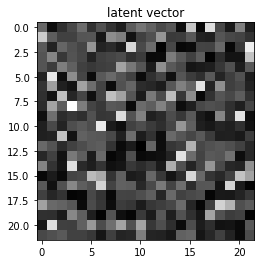

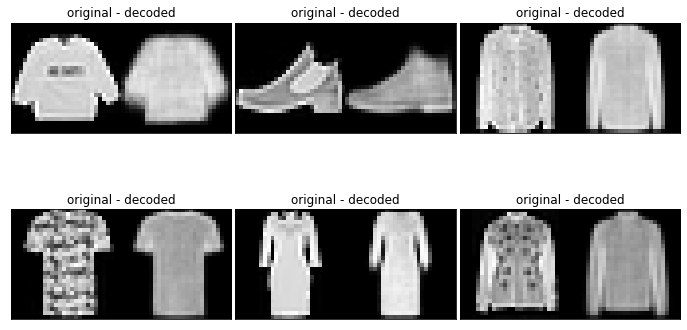

In [33]:

#Getting latent space 22 x 22:
#Train autoencoder
print("Trainning Auto Encoder Model with latent space of 484")
print("\n")
saved_path_484 = train_autoencoder(484, train_encoder_loader,val_encoder_loader)


encoder_set = AutoencoderDataset(df)
encoder_loader = DataLoader(encoder_set, shuffle=False, batch_size=64)
print("\n")
print("Retraining the Baseline Model with the encoder output")
df_encoder_484 = encoder_to_df_pipeline(484,saved_path_484, encoder_loader,22)
model_encoder_484_train_acc,model_encoder_484_val_acc  = retrain_model(df_encoder_484, 22)



Trainning Auto Encoder Model with latent space of 128


Model Architecture
Autoencoder(
  (encoder): Encoder(
    (layer1): Linear(in_features=784, out_features=712, bias=True)
    (layer2): Linear(in_features=712, out_features=640, bias=True)
    (layer3): Linear(in_features=640, out_features=512, bias=True)
    (layer4): Linear(in_features=512, out_features=144, bias=True)
  )
  (decoder): Decoder(
    (layer1): Linear(in_features=144, out_features=512, bias=True)
    (layer2): Linear(in_features=512, out_features=640, bias=True)
    (layer3): Linear(in_features=640, out_features=712, bias=True)
    (layer4): Linear(in_features=712, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
)


100%|██████████| 188/188 [00:00<00:00, 347.76it/s, Val: Epoch:0, Loss:0.025, Metric: 0.025]


Saving Model ./best_model_epoch_1_metric_0.023.ckpt
0.03657793046809862
0.023467583847897395


100%|██████████| 188/188 [00:00<00:00, 350.41it/s, Val: Epoch:1, Loss:0.021, Metric: 0.021]


Saving Model ./best_model_epoch_2_metric_0.020.ckpt
0.021270934393140827
0.019621025662494716


100%|██████████| 188/188 [00:00<00:00, 343.12it/s, Val: Epoch:2, Loss:0.020, Metric: 0.020]


Saving Model ./best_model_epoch_3_metric_0.018.ckpt
0.019136763355147822
0.018357634002332965


100%|██████████| 188/188 [00:00<00:00, 274.76it/s, Val: Epoch:3, Loss:0.019, Metric: 0.019]


Saving Model ./best_model_epoch_4_metric_0.017.ckpt
0.01787491444840571
0.017098453975031302


100%|██████████| 188/188 [00:00<00:00, 335.21it/s, Val: Epoch:4, Loss:0.017, Metric: 0.017]


Saving Model ./best_model_epoch_5_metric_0.016.ckpt
0.016339739354280198
0.015716412656561093


100%|██████████| 188/188 [00:00<00:00, 335.17it/s, Val: Epoch:5, Loss:0.017, Metric: 0.017]


Saving Model ./best_model_epoch_6_metric_0.015.ckpt
0.015260176891870252
0.015053356347221231


100%|██████████| 188/188 [00:00<00:00, 342.84it/s, Val: Epoch:6, Loss:0.016, Metric: 0.016]


Saving Model ./best_model_epoch_7_metric_0.015.ckpt
0.014568404625659776
0.014548141800024837


100%|██████████| 188/188 [00:00<00:00, 335.13it/s, Val: Epoch:7, Loss:0.016, Metric: 0.016]


Saving Model ./best_model_epoch_8_metric_0.014.ckpt
0.014011454133542574
0.014292585875385653


100%|██████████| 188/188 [00:00<00:00, 367.04it/s, Val: Epoch:8, Loss:0.015, Metric: 0.015]


Saving Model ./best_model_epoch_9_metric_0.014.ckpt
0.013568960907763631
0.013766074173704342


100%|██████████| 188/188 [00:00<00:00, 345.67it/s, Val: Epoch:9, Loss:0.015, Metric: 0.015]


Saving Model ./best_model_epoch_10_metric_0.013.ckpt
0.013109852660313427
0.013169232874162613


100%|██████████| 188/188 [00:00<00:00, 267.63it/s, Val: Epoch:10, Loss:0.014, Metric: 0.014]


Saving Model ./best_model_epoch_11_metric_0.013.ckpt
0.012774582236717529
0.0130849069270192


100%|██████████| 188/188 [00:00<00:00, 342.71it/s, Val: Epoch:11, Loss:0.014, Metric: 0.014]


Saving Model ./best_model_epoch_12_metric_0.013.ckpt
0.012486440945570462
0.012982726077396404


100%|██████████| 188/188 [00:00<00:00, 294.69it/s, Val: Epoch:12, Loss:0.013, Metric: 0.013]


Saving Model ./best_model_epoch_13_metric_0.013.ckpt
0.012223725321240098
0.012563082660553317


100%|██████████| 188/188 [00:00<00:00, 327.04it/s, Val: Epoch:13, Loss:0.014, Metric: 0.014]


Saving Model ./best_model_epoch_14_metric_0.012.ckpt
0.012003127719894468
0.012209485250490683


100%|██████████| 188/188 [00:00<00:00, 329.28it/s, Val: Epoch:14, Loss:0.013, Metric: 0.013]


Saving Model ./best_model_epoch_15_metric_0.012.ckpt
0.011753020902349056
0.01211929624831235


100%|██████████| 188/188 [00:00<00:00, 359.58it/s, Val: Epoch:15, Loss:0.013, Metric: 0.013]


Saving Model ./best_model_epoch_16_metric_0.012.ckpt
0.011535947586840066
0.012027196063802986


100%|██████████| 188/188 [00:00<00:00, 355.03it/s, Val: Epoch:16, Loss:0.013, Metric: 0.013]


Saving Model ./best_model_epoch_17_metric_0.012.ckpt
0.011399762661564604
0.01165693158668185


100%|██████████| 188/188 [00:00<00:00, 368.42it/s, Val: Epoch:17, Loss:0.013, Metric: 0.013]


Saving Model ./best_model_epoch_18_metric_0.012.ckpt
0.011208223191383834
0.011507999225859605


100%|██████████| 188/188 [00:00<00:00, 352.06it/s, Val: Epoch:18, Loss:0.012, Metric: 0.012]


Saving Model ./best_model_epoch_19_metric_0.011.ckpt
0.011007023429604726
0.01137545692522532


100%|██████████| 188/188 [00:00<00:00, 349.03it/s, Val: Epoch:19, Loss:0.012, Metric: 0.012]


Saving Model ./best_model_epoch_20_metric_0.011.ckpt
0.010902087293446223
0.011344436087975742


100%|██████████| 938/938 [00:00<00:00, 1209.58it/s]


Min Value Encoder: 3.6312081647338346e-05, Max Value: 0.9998371601104736


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)




Visualizing the latent vector of one image and some reconstructions examples


Retraining the Baseline Model with the encoder output
Model Architecture
ConvNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (drop): Dropout(p=0.1, inplace=False)
  (pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear

100%|██████████| 188/188 [00:01<00:00, 111.23it/s, Val: Epoch:0, Loss:1.417, Metric: 0.656]


Saving Model ./best_model_epoch_1_metric_0.539.ckpt
0.7363931424766977
0.5387731481481481


100%|██████████| 188/188 [00:01<00:00, 111.28it/s, Val: Epoch:2, Loss:0.738, Metric: 0.719]


Saving Model ./best_model_epoch_3_metric_0.728.ckpt
0.8142476697736352
0.7280919312169312


100%|██████████| 188/188 [00:01<00:00, 105.45it/s, Val: Epoch:3, Loss:0.398, Metric: 0.875]


Saving Model ./best_model_epoch_4_metric_0.799.ckpt
0.8217168774966711
0.7986111111111112


100%|██████████| 188/188 [00:01<00:00, 105.11it/s, Val: Epoch:5, Loss:0.427, Metric: 0.812]


Saving Model ./best_model_epoch_6_metric_0.805.ckpt
0.8293109187749668
0.8048941798941799


100%|██████████| 188/188 [00:01<00:00, 107.32it/s, Val: Epoch:9, Loss:0.467, Metric: 0.812]


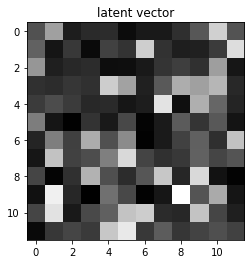

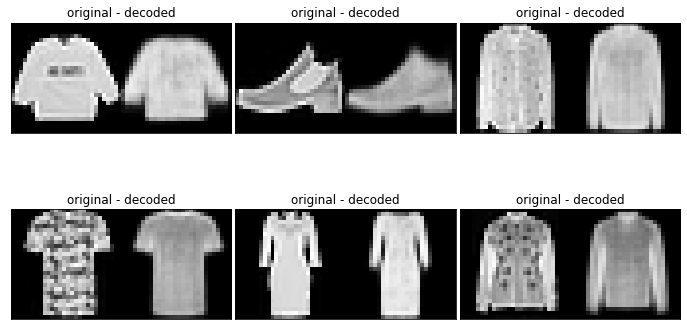

In [34]:
#Getting latent space 22 x 22:
print("Trainning Auto Encoder Model with latent space of 128")
print("\n")
saved_path_144 = train_autoencoder(144, train_encoder_loader,val_encoder_loader)

encoder_set = AutoencoderDataset(df)
encoder_loader = DataLoader(encoder_set, shuffle=False, batch_size=64)
df_encoder_144 = encoder_to_df_pipeline(144,saved_path_144, encoder_loader,12)
print("\n")
print("Retraining the Baseline Model with the encoder output")
model_encoder_144_acc_train,model_encoder_144_acc_val  = retrain_model(df_encoder_144, 12)

In [35]:
# What are the conclusions when using Autoencoders in this problem? Does accuracy improve?

Using autoencoders it was psosible to notice that through the output of the encoder network, it was possible to recover the information with the generated latent space. Although part of the information has been lost,  it can be seen from the generated decoded images that it is still possible to identify the present object.When the object of the resulting image is compared with the original object, it is noticed that there is a smoothing of the information, with the absence of details.Comparing the baseline metrics with the baseline network fed by the latent space, a reduction in the value of the metrics is noticed.Therefore, the accuracy did not improve. It is also noticed that whtn the latent vector has higher dimensions, the results are better. It was also noted that the results obtained with the PCA dimensionality reduction technique were superior to the metrics obtained with the encoder output.

|Model |Train Acc|Val Acc|
|-----|--------|--------|
|Baseline|0.935      |0.890|
|Latent Space 484  |0.8349     |0.7619|
|Latent Space 256  |     0.8293 |0.8048|




## Deadline

Monday, November 18, 11:59 pm. 

Penalty policy for late submission: You are not encouraged to submit your assignment after due date. However, in case you do, your grade will be penalized as follows:
- November 19, 11:59 pm : grade * 0.75
- November 20, 11:59 pm : grade * 0.5
- November 21, 11:59 pm : grade * 0.25


## Submission

On Google Classroom, submit your Jupyter Notebook (in Portuguese or English).

**This activity is NOT individual, it must be done in pairs (two-person group).**